# An Introduction to Differential Privacy with WhiteNoise

We take as given two desiderata for modern data analysis:

1. We want to protect the privacy of individuals.
2. We want our analyses to produce accurate information.

In this notebook we delve into the two ideas above, why they might come into conflict, and how differential privacy can help balance the two.

## Privacy

[Dinur & Nissim (2003)](http://www.cse.psu.edu/~ads22/privacy598/papers/dn03.pdf), roughly, states that if too many queries on a database are answered too accurately, the database can be reconstructed from the answeries to the queries. Before this fact was properly understood, statistical releases from databases were typically limited in ad-hoc ways. For example, an interactive querying system (in which analysts propose their own queries) may not allow queries that clearly single out individual elements of the data set. Similarly, in a one-shot release (e.g. the U.S. Census Bureau releasing statistical tables) the releasing party may decide not to release statistics on groups with fewer than some fixed number of elements. 

Releasing statistics in a differentially private manner has been posed as a principled way to ensure the privacy of individuals included in a database and prevent database reconstruction. Notably, the U.S. Census is moving to use differentially private algorithms to perform statistical releases for the 2020 Census, for fear that their old methods of privatization (a.k.a. statistical disclosure limitation) are not sufficient to prevent database reconstruction. See [here](https://dl.acm.org/ft_gateway.cfm?id=3295691&ftid=2020934&dwn=1) for more information. 

In this notebook we will focus on the one-shot release model and simulate the process of a data owner releasing aggregate statistics from a sensitive database, both with and without differential privacy. We will then attempt to reconstruct the original database from each set of releases.

### Statistical Release Setup

The underlying sensitive data from which we are releasing is a partly-synthetic version of the PUMS data that are used in many other notebooks. The data are $(500 \times 6)$ with the columns taking values as follows:

    - educ: {1, 2}
    - race: {1, 2}
    - agebinned: {'[20, 25)', '[25, 30)', ..., '[45, 50)'}
    - sex: {0, 1}
    - married: {0, 1}
    - income: [0, 420,500]

We will assume that `income` is the only sensitive variable in the database, and so the data owner is concerned only with whether or not an attacker can reconstruct the `income` variable.

We will first construct calculate a number of statistics -- `mean`, `median`, `min`, and `max` by subgroup, where a subgroup is defined as a set of database elements that are equivalent with respect to some subset of variables. For example, valid subgroups include the set of all elements with `educ == 2`, and the set of all elements with `educ == 1 && race == 2 && married == 0`. The `income` variable is never included in these subgroup definitions, as it is the variable we are trying to reconstruct. 

Throughout the notebook, we will examine various cases in which the data owner releases different subsets of these statistics.


In [1]:
import reconstruction_module as rec

# load data 
orig_data, data = rec.load_data()
non_income_data = data.drop('income', axis = 1)

# get plausible variable combinations and subset of length 5 plausible combinations 
plausible_variable_combinations = rec.get_plausible_variable_combinations(non_income_data)
plausible_variable_combinations_names = ['__'.join(combination) for combination in plausible_variable_combinations]

five_way_interactions = [combination for combination in plausible_variable_combinations if len(combination) == 5]
five_way_interactions_names = ['__'.join(combination) for combination in five_way_interactions]

# get dictionaries of private and non-private releases (up to 5-way interactions)
count_dict, priv_count_dict, mean_income_dict, priv_mean_income_dict, median_income_dict, priv_median_income_dict, min_income_dict, priv_min_income_dict, max_income_dict, priv_max_income_dict = rec.create_dicts(data, non_income_data, plausible_variable_combinations)

# get string representations of each element associated with each tuple representing the 5-way interactions
elem_dict, priv_elem_dict = rec.create_elem_dicts(count_dict, priv_count_dict, five_way_interactions, five_way_interactions_names)

### Statistical Release and Reconstruction Attack

We are nearly ready to consider an actual set of statistical releases and how this can enable a reconstruction attack, but it will be useful to first consider some details of our attacker.

The attacker's goal is to reconstruct the `income` column as closely as possible (by some definition of closeness), using a combination of the statistical releases and pre-existing knowledge of the database. We will assume for now that the attacker has no pre-existing knowledge, and thus bases their reconstruction only on the statistical releases. A natural way to do this is to attempt to construct a database that is consistent with the releases using a SAT/SMT solver. We will be using [Z3](https://github.com/Z3Prover/z3), but other SAT/SMT solvers could serve the same purpose.

Z3 takes a boolean formula with associated variables and returns whether or not the formula is satisfiable; that is, whether or not there exists a set of variable values that makes the boolean formula `TRUE`. For example, let $A,B$ be boolean variables. The formula $A \land B$ is satisfiable because it is true if $A = B = TRUE$. The formula $A \land B \land \neg B$ is not satisfiable.

This idea can be applied to finding a database that satisfies a set of statistical releases. Say we know that a subgroup has 3 elements, $\{i_1, i_2, i_3\}$ with median income $50,000$, mean income $60,000$, and min income $0$. Note that, because elements within a subgroup are equivalent with respect to the subset of variables that dedine the subset, we are free to index however we wish within the subset. We choose to enforce the element values to be montonically non-decreasing in the index. So, we can represent each statistical release as a statement we'll call an `application`: 

$$ (i_1 \leq i_2 \leq i_3) \land (i_1 = 0) \land (i_2 = 50,000) \land \left( (i_1 + i_2 + i_3)/3 = 60,000 \right). $$

In this case, we get satisfying values of $i_1, i_2$ for free and can find $i_3 = 130,000$ by plugging in $i_1, i_2$ to the last equation. So $\{0, 50,000, 130,000\}$ is a database that is consistent with our statistical release.   

Note that, as long as the set of statistical releases is internally consistent (results do not contradict one another), Z3 should be able to find at least one satisfying assignment.


In [2]:
import z3

# single satisfying assignment
i_1, i_2, i_3 = z3.Ints('i_1 i_2 i_3')
z3.solve(i_1 <= i_2, i_2 <= i_3, i_1 == 0, i_2 == 50_000, z3.Sum(i_1, i_2, i_3) == 180_000)

[i_3 = 130000, i_2 = 50000, i_1 = 0]


In the case above there is only one satisfying assignment, and so the result that Z3 provided is the only database consistent with our statistical releases. Let's now imagine the same case, but without a released median.

In [3]:
# many satisfying assignments
i_1, i_2, i_3 = z3.Ints('i_1 i_2 i_3')

z3.solve(i_1 <= i_2, i_2 <= i_3, i_1 == 0, z3.Sum(i_1, i_2, i_3) == 180_000)
z3.solve(i_1 <= i_2, i_2 <= i_3, i_1 == 0, z3.Sum(i_1, i_2, i_3) == 180_000)
z3.solve(i_1 <= i_2, i_2 <= i_3, i_1 == 0, z3.Sum(i_1, i_2, i_3) == 180_000)

[i_3 = 135119, i_2 = 44881, i_1 = 0]
[i_3 = 147454, i_2 = 32546, i_1 = 0]
[i_3 = 126911, i_2 = 53089, i_1 = 0]


Again we get a satisfying assignment, but this time the assignment is not unique. That is, there are multiple databases consistent with our statistical releases (only one of which is the true underlying data). As a result, the attacker has not learned the entire underlying database with certainty. The more satisfying assignments exist, and the more variability between these assignments, the less the attacker is expected to learn from reconstructing the data.

Now that we have a taste for Z3, we can move to the final stage of setting up the attack, encoding the statistical releases as applications. We treat each individual's income as its own variable and construct applications by asserting that the values of these variables must be consistent with statistical releases, much like we did above (but on a larger scale). For this example, we will assume that the mean and median of every subgroup is released, regardless of subgroup size.

In [4]:
# set applications
applications, priv_applications = rec.get_applications(five_way_interactions, five_way_interactions_names,
                                                plausible_variable_combinations, plausible_variable_combinations_names,
                                                count_dict, priv_count_dict, 
                                                mean_income_dict, priv_mean_income_dict,
                                                median_income_dict, priv_median_income_dict,
                                                min_income_dict, priv_min_income_dict,
                                                max_income_dict, priv_max_income_dict,
                                                elem_dict, priv_elem_dict, lowest_allowable_count = 1,
                                                use_medians = True, use_mins = False, use_maxes = False)
# remove duplicate applications
applications = list(set(applications))
priv_applications = list(set(priv_applications))

### Attack #1

In [5]:
# initialize solvers
solver_1, solver_list_1 = rec.applications_to_solver(applications)
priv_solver_1, priv_solver_list_1 = rec.applications_to_solver(priv_applications) 

# get results (models)
model_1 = rec.check_solution(solver_1) 
if model_1:
    print('non-private: sat')
else:
    print('non-private: unsat')

# attempt to resconstruct data
recon_data = rec.reconstruct_data(model_1, elem_dict)

non-private: sat


As expected, Z3 produces a satisfying assignment based on the non-private statistical releases.

We mentioned earlier that there may exist multiple satisfying assignments and that we can consider the number and variability of these assignments to examine the extent to which an attacker can learn from a satisfying assignment. We will not do that here, instead opting to just compare the assignment to the true underlying data (a luxury the attacker will not have).

In [6]:
# compare original and reconstructed data
orig_data, recon_data, exact, within_2k, within_5k = rec.compare_data(orig_data, recon_data)

print('Of 500 total incomes:')
print('    {0} incomes reconstructed exactly'.format(exact))
print('    {0} incomes resconstructed within $2,000'.format(within_2k))
print('    {0} incomes resconstructed within $5,000'.format(within_5k))

Of 500 total incomes:
    52 incomes reconstructed exactly
    155 incomes resconstructed within $2,000
    210 incomes resconstructed within $5,000


In the example above, we did not make any effort at statistical disclosure limitation. We can try the attack again, but in this case imagine that no information (counts, means, or medians) are released for subgroups of size $< 10$. 

### Attack #2

In [7]:
# set applications
applications_2, priv_applications_2 = rec.get_applications(five_way_interactions, five_way_interactions_names,
                                                plausible_variable_combinations, plausible_variable_combinations_names,
                                                count_dict, priv_count_dict, 
                                                mean_income_dict, priv_mean_income_dict,
                                                median_income_dict, priv_median_income_dict,
                                                min_income_dict, priv_min_income_dict,
                                                max_income_dict, priv_max_income_dict,
                                                elem_dict, priv_elem_dict, lowest_allowable_count = 10,
                                                use_medians = True, use_mins = False, use_maxes = False)
# remove duplicate applications
applications_2 = list(set(applications_2))
priv_applications_2 = list(set(priv_applications_2))

# initialize solvers
solver_2, solver_list_2 = rec.applications_to_solver(applications_2)
priv_solver_2, priv_solver_list_2 = rec.applications_to_solver(priv_applications_2) 

# get results (models)
model_2 = rec.check_solution(solver_2) 
if model_2:
    print('non-private: sat')
else:
    print('non-private: unsat')

# attempt to resconstruct data
recon_data_2 = rec.reconstruct_data(model_2, elem_dict)

# compare original and reconstructed data
orig_data, recon_data_2, exact_2, within_2k_2, within_5k_2 = rec.compare_data(orig_data, recon_data_2)

print('Of 500 total incomes:')
print('    {0} incomes reconstructed exactly'.format(exact_2))
print('    {0} incomes resconstructed within $2,000'.format(within_2k_2))
print('    {0} incomes resconstructed within $5,000'.format(within_5k_2))

non-private: sat
Of 500 total incomes:
    52 incomes reconstructed exactly
    85 incomes resconstructed within $2,000
    113 incomes resconstructed within $5,000


After suppressing all statistics from subgroups of size $< 10$, the attacker is able to reconstruct the data with some success (though less than in the setting with no suppression).

To this point, we have considered the setting in which the attacker knows only the values of the aggregate statistics released. However, it is possible that attackers have access to information not contained in this set of statistical releases. For example, perhaps they have access to statistical releases from another source, or they happen to already know exact values for some elements in the database.

### Attack 3

Imagine that the attacker has access to the following information outside of the statistical releases:

- There is at least one person in the data with `educ == 2`, `race == 2`, `agebinned == [45, 50)`, `sex == 0`, and `married == 1` with an income of $95,000.

- There is only one person in the data with `educ == 2`, `race == 2`, `agebinned == [45, 50)`, `sex == 1`, and `married == 1` and they have an income of $31,000.

In [8]:
# set applications
applications_3, priv_applications_3 = rec.get_applications(five_way_interactions, five_way_interactions_names,
                                                plausible_variable_combinations, plausible_variable_combinations_names,
                                                count_dict, priv_count_dict, 
                                                mean_income_dict, priv_mean_income_dict,
                                                median_income_dict, priv_median_income_dict,
                                                min_income_dict, priv_min_income_dict,
                                                max_income_dict, priv_max_income_dict,
                                                elem_dict, priv_elem_dict, lowest_allowable_count = 10,
                                                use_medians = True, use_mins = False, use_maxes = False)
# remove duplicate applications
applications_3 = list(set(applications_3))
priv_applications_3 = list(set(priv_applications_3))

# initialize solvers
solver_3, solver_list_3 = rec.applications_to_solver(applications_3)
priv_solver_3, priv_solver_list_3 = rec.applications_to_solver(priv_applications_3) 

# add applications encoding existing attacker knowledge
group_1_def = 'educ_2__race_2__agebinned_45,50__sex_0__married_1'
group_1_elems = [z3.Int('{0}_{1}'.format(group_1_def, i)) for i in range(count_dict[group_1_def])]
solver_3.add(z3.Or([elem == 95_000 for elem in group_1_elems]))

group_2_def = 'educ_2__race_2__agebinned_45,50__sex_1__married_1'
solver_3.add(z3.Int( '{0}_{1}'.format(group_2_def, 0)) == 31_000)

# get results (models)
model_3 = rec.check_solution(solver_3) 
if model_3:
    print('non-private: sat')
else:
    print('non-private: unsat')

# attempt to resconstruct data
recon_data_3 = rec.reconstruct_data(model_3, elem_dict)

# compare original and reconstructed data
orig_data, recon_data_3, exact_3, within_2k_3, within_5k_3 = rec.compare_data(orig_data, recon_data_3)

print('Of 500 total incomes:')
print('    {0} incomes reconstructed exactly'.format(exact_3))
print('    {0} incomes resconstructed within $2,000'.format(within_2k_3))
print('    {0} incomes resconstructed within $5,000'.format(within_5k_3))

non-private: sat
Of 500 total incomes:
    54 incomes reconstructed exactly
    97 incomes resconstructed within $2,000
    128 incomes resconstructed within $5,000


In each of the three scenarios above, we also set up (but did not test) reconstruction attempts with differentially private statistical releases. Let's now see what happens if we try to reconstruct the underlying data from the private statistics.

In [9]:
# get results (models)
priv_model_1 = rec.check_solution(priv_solver_1) 
if priv_model_1:
    print('model_1 private: sat')
else:
    print('model_1 private: unsat')

priv_model_2 = rec.check_solution(priv_solver_2) 
if priv_model_2:
    print('model_2 private: sat')
else:
    print('model_2 private: unsat')
    
priv_model_3 = rec.check_solution(priv_solver_3) 
if priv_model_3:
    print('model_3 private: sat')
else:
    print('model_3 private: unsat')

model_1 private: unsat
model_2 private: unsat
model_3 private: unsat


In each case, Z3 cannot find a satisfying assignment (a database that is consistent with the released statistics).

## Utility

To this point, we have addressed only that aggregate statistics are not as private as they may seem at first glance and how differential privacy can help. We can now move to considering the accuracy of our differentially private statistics.

In general, the accuracy of a differentially private statistic scales with the desired privacy level and size of the underlying data. More privacy requires less accuracy, and more data allows for more accuracy.

Below, we examine the relationship between non-private and private results we released. Specifically, we consider the mean income for every subgroup we defined, relative to the privately-released mean income for the same subgroup. For diagnostic purposes, we plot subgroups with $\geq 100$ individuals in one plot, and those with $< 100$ individuals in another. 

In [17]:
import seaborn as sns
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

df = pd.DataFrame({'group': list(mean_income_dict.keys())})
df['group_count'] = [count_dict[group_name] for group_name in df['group']]
df['group_priv_count'] = [priv_count_dict[group_name] for group_name in df['group']]
df['group_mean'] = [mean_income_dict[group_name] for group_name in df['group']]
df['group_priv_mean'] = [priv_mean_income_dict[group_name] for group_name in df['group']]
df['group_log_mean'] = [np.log(mean_income_dict[group_name] + 1) for group_name in df['group']]
df['group_priv_log_mean'] = [np.log(priv_mean_income_dict[group_name] + 1) for group_name in df['group']]

Text(0.5, 1.0, 'Non-Private vs. Private Means: Group Size >= 100')

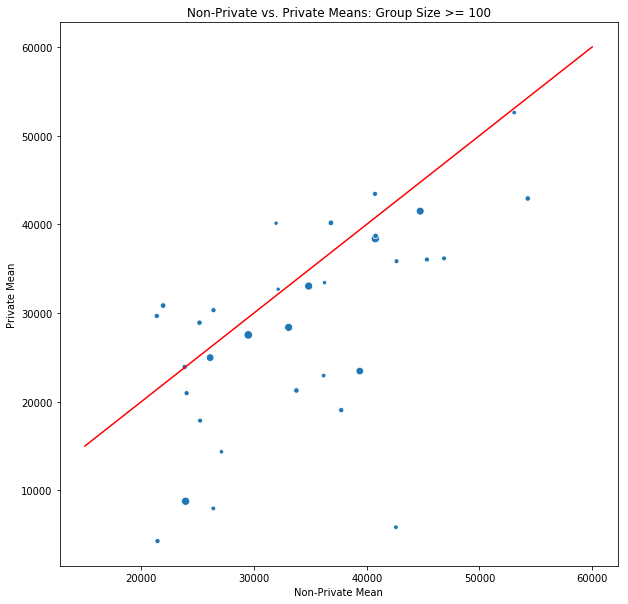

In [18]:
sns.scatterplot(x = 'group_mean', y = 'group_priv_mean', size = 'group_count', legend = False, data = df.loc[df['group_count'] >= 100])
plt.plot(np.linspace(15_000, 60_000, 100), np.linspace(15_000, 60_000, 100), color = 'red')
plt.xlabel('Non-Private Mean')
plt.ylabel('Private Mean')
plt.title('Non-Private vs. Private Means: Group Size >= 100')

Text(0.5, 1.0, 'Non-Private vs. Private Means: Group Size < 100')

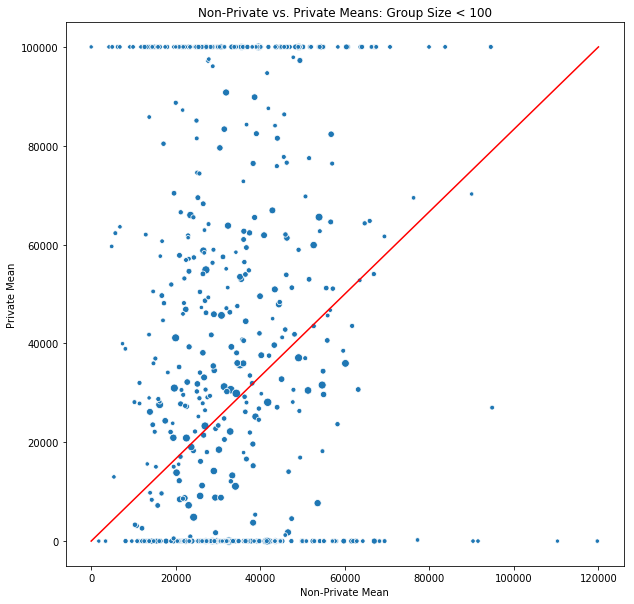

In [19]:
sns.scatterplot(x = 'group_mean', y = 'group_priv_mean', size = 'group_count', legend = False, data = df.loc[df['group_count'] < 100])
plt.plot(np.linspace(0, 120_000, 100), np.linspace(0, 100_000, 100), color = 'red')
plt.xlabel('Non-Private Mean')
plt.ylabel('Private Mean')
plt.title('Non-Private vs. Private Means: Group Size < 100')

The error is, as expected, more pronounced for the groups with smaller sample sizes.

We can pivot slightly and imagine a scenario in which we are an analyst with permission to query the underlying data through WhiteNoise, rather than receiving a pre-determined set of statistical releases. Let's say we want to understand the distribution of income for people with `educ == 1`.

In [20]:
import whitenoise
import whitenoise.components as op

# define sample of interest
sample_of_interest = orig_data.loc[orig_data['educ'] == 1]

# define bin edges
hist_edges = list(range(0, 110000, 10000))


# get non-private histogram values
binned_income = pd.cut(sample_of_interest['income'], hist_edges, right = False)
binned_income = binned_income.cat.add_categories('>= 100,000')
binned_income.fillna('>= 100,000', inplace = True)
non_priv_hist = list(binned_income.value_counts().sort_index())

# get differentially private histogram
with whitenoise.Analysis() as analysis:
    data = whitenoise.Dataset(value = list(sample_of_interest['income']), 
                              column_names = ['income'])
    
    dp_histogram = op.dp_histogram(
        op.cast(data, type = 'int', lower = 0, upper = 100_000),
        edges = hist_edges,
        upper = 500,
        null_value = 1_000_000,
        privacy_usage = {'epsilon': 1.}
    )
analysis.release()
priv_hist = list(dp_histogram.value)    

# post-process dp histogram
priv_hist = [max(0, count) for count in priv_hist]

In [21]:
# create data frame for plotting
df = pd.DataFrame({'income': [str(cat) for cat in list(binned_income.cat.categories)] * 2,
                   'count': non_priv_hist + priv_hist,
                   'version': ['non-private'] * len(non_priv_hist) + ['private'] * len(priv_hist)})

Text(0.5, 1.0, 'Distribution of income for individuals with "educ == 1"')

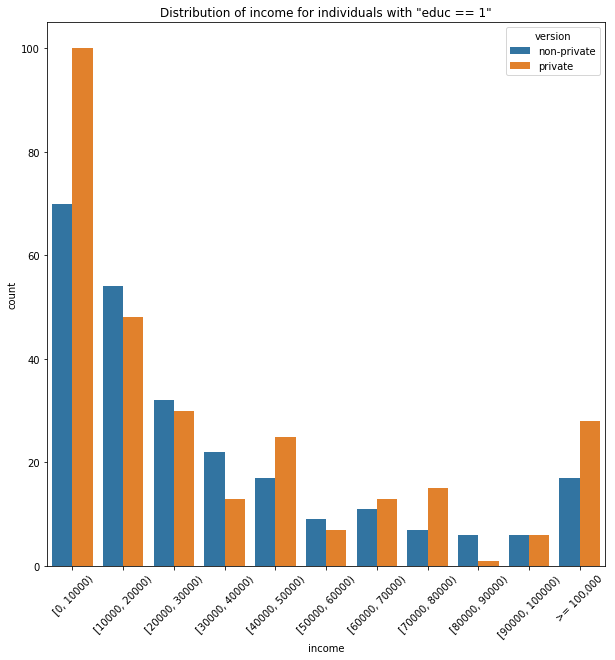

In [22]:
sns.barplot(x = 'income', y = 'count', hue = 'version', data = df)
plt.xticks(rotation = 45)
plt.title('Distribution of income for individuals with "educ == 1"')